In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.5 MB/s 
     |████████████████████████████████| 77 kB 4.5 MB/s 
     |████████████████████████████████| 895 kB 35.8 MB/s 
     |████████████████████████████████| 6.6 MB 35.3 MB/s 
     |████████████████████████████████| 596 kB 18.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
!pip install demoji

     |████████████████████████████████| 42 kB 830 kB/s 


In [4]:
!pip install flashtext

  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9309 sha256=5d54fad0d04639bc1bdfc573a1ba8f6cfd463a8350a073f26b41eea0fa47bb03
  Stored in directory: /root/.cache/pip/wheels/cb/19/58/4e8fdd0009a7f89dbce3c18fff2e0d0fa201d5cdfd16f113b7
Successfully built flashtext


In [5]:
!pip install pyspellchecker

     |████████████████████████████████| 2.7 MB 5.0 MB/s 


In [6]:
!pip install unidecode

     |████████████████████████████████| 235 kB 5.2 MB/s 


In [7]:
!pip install emot

     |████████████████████████████████| 61 kB 14 kB/s 


In [8]:
import os # OS path
import numpy as np # NumPy
import pandas as pd # Files read
import re # Regex for strings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchtext import datasets
from collections import defaultdict
from typing import Dict, List
from torch import Tensor
import torch
import torch.nn as nn
#from transformers.models.bert.tokenization_bert import BasicTokenizer
import math
from transformers.models.bert.tokenization_bert import BasicTokenizer
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import words
nltk.download('words')
import demoji
demoji.download_codes()
from spellchecker import SpellChecker
from emot.emo_unicode import UNICODE_EMOJI, UNICODE_EMOJI_ALIAS, EMOTICONS_EMO
from flashtext import KeywordProcessor
import unidecode
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.


In [9]:
import gensim.downloader as api
glove_model = api.load('glove-twitter-200')

[==================================================] 100.0% 758.5/758.5MB downloaded


In [10]:
root_path = 'gdrive/MyDrive/Colab Notebooks/proiect-deeplearning-emocontext/'

In [11]:
tweet_tokenizer = TweetTokenizer()

In [12]:
def token_custom(sent):
  all_emoji_emoticons = {**EMOTICONS_EMO,**UNICODE_EMOJI_ALIAS, **UNICODE_EMOJI_ALIAS}
  all_emoji_emoticons = {k:v.replace(":","").replace("_"," ").strip() for k,v in all_emoji_emoticons.items()}

  kp_all_emoji_emoticons = KeywordProcessor()
  for k,v in all_emoji_emoticons.items():
      kp_all_emoji_emoticons.add_keyword(k, v)

  emoji_d = demoji.findall(sent)
  for i in range(len(sent)):
    if sent[i] not in emoji_d:
      if unidecode.unidecode(sent[i]) != "":
        sent = sent.replace(sent[i], unidecode.unidecode(sent[i]))

  text = kp_all_emoji_emoticons.replace_keywords(sent) # transform din emoticon in text
  tokenized = tweet_tokenizer.tokenize(text)

  turn_utt = []
  spell = SpellChecker()

  for i in range(len(tokenized)):
    emoji_d = demoji.findall(tokenized[i])
    if tokenized[i] in emoji_d:
      tokenized[i] = emoji_d[tokenized[i]] # transform din emoji in text

    word_tokenized = tweet_tokenizer.tokenize(tokenized[i])
    for word in word_tokenized:
      word = word.lower()
      word = re.sub(r'(.)\1+', r'\1\1', word)
      word = spell.correction(word)
      turn_utt.append(word)

  return turn_utt


#sent = "İ Don't worry  I'm girl 😘😍😻 ;) :) :)) !"
sent = "🖑😂"
print(token_custom(sent))

['i', 'joy']


In [13]:
# litere mici, corectat, repeated ch
data = pd.read_csv(root_path + 'train.txt', sep='\t', header=0)
anw = 0
min_len = math.inf
max_len = 0
emoji_nr = 0

word_count = defaultdict(int)
train_data, train_labels = [], [] 

for idx, row in data.iterrows(): 
  words_row = 0
  len_c_row = 0
  row_utt = []

  for turn in row[1:4]:
    words_row += len(turn.split())
    len_c_row += len(turn)
    emoji_nr += len(demoji.findall_list(turn))

    row_utt.append(token_custom(turn))

  train_data.append(row_utt[0] + row_utt[1] + row_utt[2])
  for tok in train_data[-1]:
        word_count[tok] += 1

  if row[4] == 'happy':
    train_labels.append(0)
  elif row[4] == 'sad':
    train_labels.append(1)
  elif row[4] == 'angry':
    train_labels.append(2)
  elif row[4] == 'others':
    train_labels.append(3)

  if(max_len < len_c_row):
    max_len = len_c_row #max nr of characters
  if(min_len > len_c_row):
    min_len = len_c_row # min nr of  characters

  anw += words_row

  if idx > 800:
    break



anw = anw/len(data) #avg words/examples
emoji_avg = emoji_nr/len(data)
print(anw, max_len, min_len,emoji_avg)

0.35881962864721484 284 8 0.010742705570291777


In [ ]:
anw = 0
min_len = math.inf
max_len = 0
emoji_nr = 0
data_t_l =0
fisiere_intrare =["train.txt","dev.txt","test.txt"]
for intrare in fisiere_intrare:
    data = pd.read_csv(root_path + intrare, sep='\t', header=0)



    word_count = defaultdict(int)
    train_data, train_labels = [], [] 

    for idx, row in data.iterrows(): 
      words_row = 0
      len_c_row = 0
      row_utt = []

      for turn in row[1:4]:
        words_row += len(turn.split())
        len_c_row += len(turn)
        emoji_nr += len(demoji.findall_list(turn))

      if(max_len < len_c_row):
        max_len = len_c_row #max nr of characters
      if(min_len > len_c_row):
        min_len = len_c_row # min nr of  characters

      anw += words_row
    data_t_l += len(data)

anw = anw/data_t_l #avg words/examples
emoji_avg = emoji_nr/data_t_l
print(anw, max_len, min_len,emoji_avg)

In [15]:
data = pd.read_csv(root_path + 'dev.txt', sep='\t', header=0)
anw = 0
min_len = math.inf
max_len = 0

val_data, val_labels = [], []

for idx, row in data.iterrows(): 
  words_row = 0
  len_c_row = 0
  row_utt = []

  for turn in row[1:4]:
    words_row += len(turn.split())
    len_c_row += len(turn)

    row_utt.append(token_custom(turn))

  val_data.append(row_utt[0] + row_utt[1] + row_utt[2])

  if row[4] == 'happy':
    val_labels.append(0)
  elif row[4] == 'sad':
    val_labels.append(1)
  elif row[4] == 'angry':
    val_labels.append(2)
  elif row[4] == 'others':
    val_labels.append(3)

  if(max_len < len_c_row):
    max_len = len_c_row #max nr of characters
  if(min_len > len_c_row):
    min_len = len_c_row # min nr of  characters

  anw += words_row

  if idx > 200:
    break

In [14]:
print(len(train_labels))

802


In [16]:
class MLPNN(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 dropout_p: float,
                 hidden_activation_fn = nn.Tanh()):
      
        super().__init__()
        self.layer_1 = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.activation_fn = hidden_activation_fn
        self.dropout = nn.Dropout(dropout_p)
   
    def forward(self, x):
      out = self.activation_fn(self.layer_1(x))
      out = self.dropout(out)
      out = self.output_layer(out)
      return out

In [17]:
class MLPDataset(Dataset):
    def __init__(self, 
                 tokenized_examples: List[List[str]], 
                 labels: List):
        """
        tokenized_examples: lista de propozitii deja tokenizate
        labels: lista cu label-urile corecte pentru fiecare propozitie
        vocab: vocabular
        """
        self.data = tokenized_examples
        self.labels = torch.LongTensor(labels)

    def __getitem__(self, index):
        """
        index: indexul exemplului din setul nostru de date
        Functia reprezinta fiecare cuvant cu indicele corespunzator din Vocabular:
          ['wear', 'masks', '!'] => [31, 85, 422]

        Pentru exemplul de la pozitia `index`, intoarcem un Tensor cu 
        indicii cuvintelor sale si un Tensor cu label-ul aferent.
        """
        word2vec = []
        for it in self.data[index]:
          try:
            word2vec.append(glove_model[it])
          except:
            continue 

        mean_vec = np.mean(word2vec, axis=0)
        return torch.tensor(mean_vec), torch.LongTensor([self.labels[index]])

    def __len__(self) -> int:
        return len(self.data)

In [55]:
train_dataset = MLPDataset(train_data, train_labels)
val_dataset = MLPDataset(val_data, val_labels)

train_sampler = RandomSampler(train_dataset)
val_sampler = RandomSampler(val_dataset)

train_dataloader = DataLoader(train_dataset, batch_size = 16, sampler = train_sampler)
val_dataloader = DataLoader(val_dataset, batch_size = 16, sampler = val_sampler)

In [22]:
def train_epoch(model, train_dataloader, loss_crt, optimizer, device):
    """
    model: Model object 
    train_dataloader: DataLoader over the training dataset
    loss_crt: loss function object
    optimizer: Optimizer object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns: 
     - the epoch training loss, which is an average over the individual batch
       losses
     - the predictions made by the model
     - the labels 
    """
    model.train()
    epoch_loss = 0.0
    num_batches = len(train_dataloader)
    predictions = []
    labels = []
    for idx, batch in enumerate(train_dataloader):
        batch_data, batch_labels = batch
        current_batch_size = batch_data.size(0)

        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        output = model(batch_data)
        batch_predictions = torch.argmax(output, dim=1)
        
        predictions += batch_predictions.tolist()
        labels += batch_labels.squeeze().tolist()

        loss = loss_crt(output, batch_labels.squeeze())
        loss_scalar = loss.item()

        loss.backward()

        optimizer.step()
        model.zero_grad()

        epoch_loss += loss_scalar

    epoch_loss = epoch_loss/num_batches

    return epoch_loss, predictions, labels

def eval_epoch(model, val_dataloader, loss_crt, device):
    """
    model: Model object 
    val_dataloader: DataLoader over the validation dataset
    loss_crt: loss function object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns: 
     - the epoch validation loss, which is an average over the individual batch
       losses
     - the predictions made by the model
     - the labels 
    """
    model.eval()
    epoch_loss = 0.0
    num_batches = len(val_dataloader)
    predictions = []
    labels = []
    with torch.no_grad():
        for idx, batch in enumerate(val_dataloader):
            batch_data, batch_labels = batch
            current_batch_size = batch_data.size(0)

            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            output = model(batch_data)
            batch_predictions = torch.argmax(output, dim=1)
        
            predictions += batch_predictions.tolist()
            labels += batch_labels.squeeze().tolist()

            loss = loss_crt(output, batch_labels.squeeze())
            loss_scalar = loss.item()

            epoch_loss += loss_scalar

    epoch_loss = epoch_loss/num_batches

    return epoch_loss, predictions, labels

In [20]:
def compute_accuracy(predictions: List[int], labels:List[int]) -> float:
    """
    Compute accuracy given the predictions of a binary classifier and the 
    ground truth label.
    predictions: list of model predictions (0 or 1)
    labels: list of ground truth labels (0 or 1)
    """
    num_correct = len([(p,l) for (p,l) in zip(predictions,labels) if p==l])
    epoch_accuracy = num_correct/len(labels)
    
    return epoch_accuracy

In [64]:
hyperparams = {
    'lr': 0.0001,
    'num_epochs': 100,
    'hidden_size': 512,
    'output_size': 4,
    'dropout': 0.6,
    'activation_fn': nn.ReLU()
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_criterion = nn.CrossEntropyLoss()

model = MLPNN(
    input_size = 200, # folosesc 200 features deoarece am ales glove cu varianta D=200
    hidden_size = hyperparams['hidden_size'],
    output_size = hyperparams['output_size'],
    dropout_p = hyperparams['dropout'],
    hidden_activation_fn = hyperparams['activation_fn']
)
model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=hyperparams['lr'], weight_decay=0.000001)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0

for epoch_idx in range(hyperparams['num_epochs']):
    train_epoch_loss, train_predictions, train_labels = train_epoch(
        model, 
        train_dataloader, 
        loss_criterion, 
        optimizer,
        device
    )
    val_epoch_loss, val_predictions, val_labels = eval_epoch(
        model,
        val_dataloader,
        loss_criterion,
        device
    )
    train_acc = compute_accuracy(train_predictions, train_labels)
    val_acc = compute_accuracy(val_predictions, val_labels)
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    

    print("epoch %d, train loss=%f, train acc=%f, val loss=%f, val acc=%f" % (
        epoch_idx, 
        train_epoch_loss,
        train_acc,
        val_epoch_loss,
        val_acc
    ))

epoch 0, train loss=1.336345, train acc=0.421446, val loss=1.106607, val acc=0.841584
epoch 1, train loss=1.268044, train acc=0.500000, val loss=0.975517, val acc=0.841584
epoch 2, train loss=1.232705, train acc=0.500000, val loss=0.922560, val acc=0.841584
epoch 3, train loss=1.239100, train acc=0.500000, val loss=0.897946, val acc=0.841584
epoch 4, train loss=1.229948, train acc=0.500000, val loss=0.883629, val acc=0.841584
epoch 5, train loss=1.234998, train acc=0.500000, val loss=0.882942, val acc=0.841584
epoch 6, train loss=1.246738, train acc=0.500000, val loss=0.895163, val acc=0.841584
epoch 7, train loss=1.228634, train acc=0.500000, val loss=0.896409, val acc=0.841584
epoch 8, train loss=1.220427, train acc=0.500000, val loss=0.885063, val acc=0.841584
epoch 9, train loss=1.222285, train acc=0.500000, val loss=0.883988, val acc=0.841584
epoch 10, train loss=1.232621, train acc=0.500000, val loss=0.894219, val acc=0.841584
epoch 11, train loss=1.215565, train acc=0.500000, va

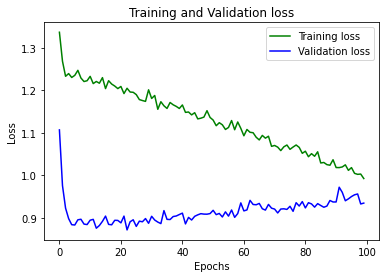

In [65]:
%matplotlib inline
NUM_EPOCHS=hyperparams['num_epochs']
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

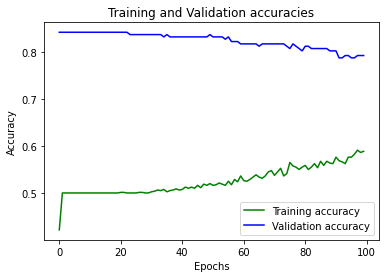

In [66]:
plt.plot(range(0,len(train_accuracies)), train_accuracies, 'g', label='Training accuracy')
plt.plot(range(0,len(train_accuracies)), val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

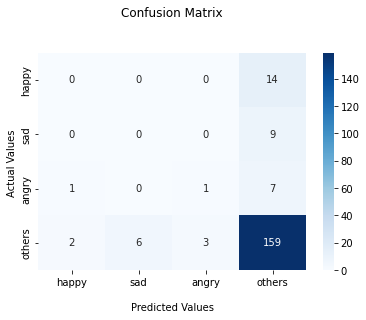

In [67]:
import seaborn as sns

cf_matrix = confusion_matrix(val_labels, val_predictions, labels=[0, 1, 2, 3])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["happy", "sad", "angry", "others"])
ax.yaxis.set_ticklabels(["happy", "sad", "angry", "others"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [68]:
precision_recall_fscore_support(val_labels, val_predictions, zero_division=0)

(array([0.        , 0.        , 0.25      , 0.84126984]),
 array([0.        , 0.        , 0.11111111, 0.93529412]),
 array([0.        , 0.        , 0.15384615, 0.88579387]),
 array([ 14,   9,   9, 170]))

# LSTM

In [69]:
class Vocabulary:
    """
    Vocabularul e un dictionar care ne tine corespondenta dintre cuvinte si
    indici unici. Fiecare cuvant are un indice unic => o propozitie devine
    o lista de indici.

    Reteaua va primii un tensor de dimensiune batch_size x max_timesteps, pe
    care il va da stratului de Embedding, care asociaza fiecarui cuvant un
    vector. Din stratul Embedding va rezulta un tensor de dimensiune:
      batch_size x max_timesteps x embedding_dim
    
    Daca avem urmatorul batch de 2 tweeturi:
    [[fake, news, everywhere, people, !],
     [masks, are, great]
    ], 
    atunci inputul nostru va fi un Tensor de dimensiune 2 x 5:
      x = torch.LongTensor([
        [32, 95, 13, 387, 88],
        [971, 18, 31, 0, 0]
      ]),
    unde 0 este indicele pentru tokenul special [PAD], pe care il appenduim la
    secventele mai scurte.
    """
    def __init__(self, word_count: Dict[str, int], min_freq: int):
        """
        word_count: dictionar cuvant -> frecventa cuvant in corpus 
                    (il puteti calcula acolo unde calculati si list_of_words)
        min_freq: frecventa minima de aparitie a unui cuvant; orice e sub
          il consideram token 'unknown' si il vom reprezenta cu '[UNK]'.
        """
        # [pad] e un token special pe care il appenduim la secventele mai scurte
        # dintr-un mini-batch
        # [unk] e un token pentru cuvinte necunoscute (de obicei cuvinte rare, 
        # cu frecventa mica, pe care o stabilim noi de obicei)
        self.word_to_idx = {'[pad]': 0, '[unk]':1}
        next_index = 2

        # actualizare dictionar 
        for word, freq in word_count.items():
            if freq >= min_freq:
              self.word_to_idx[word] = next_index
              next_index += 1
        
        # mapare inversa
        self.idx_to_char = {idx: word for (word, idx) in self.word_to_idx.items()}
   
    def size(self):
        return len(self.word_to_idx)
      
    def __str__(self):
        return str(self.word_to_idx)

In [70]:
print(word_count.items())
vocab = Vocabulary(word_count=word_count, min_freq=1)

dict_items([("don't", 80), ('worry', 3), ("i'm", 64), ('girl', 9), ('him', 11), ('how', 91), ('do', 89), ('i', 790), ('know', 83), ('if', 29), ('you', 572), ('are', 153), ("what's", 5), ('ur', 23), ('name', 12), ('?', 389), ('when', 15), ('did', 21), ('saw', 4), ('many', 11), ('times', 6), ('think', 20), ('-', 7), ('_', 2), ('no', 63), ('.', 284), ('never', 16), ('by', 18), ('google', 4), ('chrome', 1), ('where', 24), ('live', 5), ('u', 179), ('ridiculous', 2), ('might', 3), ('be', 47), ('but', 73), ('am', 102), ('telling', 2), ('the', 121), ('truth', 4), ('little', 5), ('disgusting', 1), ('whore', 1), ('just', 53), ('for', 62), ('time', 17), ('pass', 2), ('it', 129), ('4', 5), ('a', 134), ('living', 4), ('then', 34), ('maybe', 4), ('dog', 2), ('person', 8), ('youre', 2), ('so', 123), ('rude', 12), ('what', 177), ('why', 70), ('whassup', 1), ('nothing', 26), ('much', 20), ('sitting', 1), ('sipping', 1), ('and', 77), ('watching', 2), ('to', 212), ('abt', 3), ('on', 37), ('ok', 60), ('im

In [71]:
print(getattr(vocab, "word_to_idx"))

{'[pad]': 0, '[unk]': 1, "don't": 2, 'worry': 3, "i'm": 4, 'girl': 5, 'him': 6, 'how': 7, 'do': 8, 'i': 9, 'know': 10, 'if': 11, 'you': 12, 'are': 13, "what's": 14, 'ur': 15, 'name': 16, '?': 17, 'when': 18, 'did': 19, 'saw': 20, 'many': 21, 'times': 22, 'think': 23, '-': 24, '_': 25, 'no': 26, '.': 27, 'never': 28, 'by': 29, 'google': 30, 'chrome': 31, 'where': 32, 'live': 33, 'u': 34, 'ridiculous': 35, 'might': 36, 'be': 37, 'but': 38, 'am': 39, 'telling': 40, 'the': 41, 'truth': 42, 'little': 43, 'disgusting': 44, 'whore': 45, 'just': 46, 'for': 47, 'time': 48, 'pass': 49, 'it': 50, '4': 51, 'a': 52, 'living': 53, 'then': 54, 'maybe': 55, 'dog': 56, 'person': 57, 'youre': 58, 'so': 59, 'rude': 60, 'what': 61, 'why': 62, 'whassup': 63, 'nothing': 64, 'much': 65, 'sitting': 66, 'sipping': 67, 'and': 68, 'watching': 69, 'to': 70, 'abt': 71, 'on': 72, 'ok': 73, 'im': 74, 'back': 75, '!': 76, ',': 77, 'really': 78, 'y': 79, 'saying': 80, 'can': 81, 'hear': 82, 'bay': 83, 'in': 84, 'kissi

In [72]:
class LSTMDataset(Dataset):
    def __init__(self, 
                 tokenized_examples: List[List[str]], 
                 labels: List,
                 vocab: Vocabulary):
        """
        tokenized_examples: lista de propozitii deja tokenizate
        labels: lista cu label-urile corecte pentru fiecare propozitie
        vocab: vocabular
        """
        self.data = tokenized_examples
        self.labels = torch.LongTensor(labels)
        self.vocabulary = vocab

    def __getitem__(self, index):
        """
        index: indexul exemplului din setul nostru de date
        Functia reprezinta fiecare cuvant cu indicele corespunzator din Vocabular:
          ['wear', 'masks', '!'] => [31, 85, 422]

        Pentru exemplul de la pozitia `index`, intoarcem un Tensor cu 
        indicii cuvintelor sale si un Tensor cu label-ul aferent.
        """
        example_indices = []
        example = self.data[index]
        # TODO: convertiti cuvintele din exemplu la indicii din vocabular
        # si adaugati indicii in example_indices
        for it in example:
          if it in vocab.word_to_idx:
            example_indices.append(getattr(vocab, "word_to_idx")[it])
          else:
            example_indices.append(1)

        return torch.LongTensor(example_indices), torch.LongTensor([self.labels[index]])

    def __len__(self) -> int:
        return len(self.data)

In [73]:
def collate_examples(batch_data):
    """
    Avem nevoie de aceasta functie in DataLoader pentru ca exemplele
    noastre din batch au lungimi diferite si vrem sa le punem intr-un 
    singur tensor de dimensiune batch_size x max_timesteps

    Functia primeste o lista de tupluri (input, label) de lungime batch_size.
    input este un Tensor cu indicii cuvintelor dintr-un exemplu 
    (asa cum e el intors de Dataset.__getitem__). label este un Tensor cu 1
    element (clasa corecta).

    De exemplu, daca avem urmatorul batch de 2 tweeturi:
      [[fake, news, everywhere, people, !],
       [masks, are, great]
      ], 
    atunci ele vor fi reprezentate ca o lista cu 2 Tensori:
        [torch.tensor([32, 95, 13, 387, 88],
         torch.tensor([971, 18, 31]),
        ]
    Noi trebuie sa calculam cea mai lunga secventa din batch (5 in exemplul de
    mai sus), sa cream un tensor de lungime batch_size x max_timesteps, pe
    care il umplem cu datele noastre, si la care appenduim '0' la exemplele
    mai scurte. O sa ne rezulte:
       torch.tensor([[32, 95, 13, 387, 88],
                     [971, 18, 31, 0, 0]
                    ])
    De asemenea vom intoarce si un tensor de lungime batch_size, in care
    avem label-urile corecte pentru exemplele noastre
    """
    # lista cu tensori de lungime variabila
    batch_input = [e[0] for e in batch_data]
    #print("batch_input = ", batch_input)

    # lista cu Tensori cu 1 element (clasa corecta per exemplu)
    batch_labels = [e[1] for e in batch_data]
    #print("batch_labels = ", batch_labels)

    # TODO: calculati cel mai lung exemplu din batch_data
    max_len = 0
    for input in batch_input:
      max_len = max(max_len, len(input)) 

    batch_input_tensor = torch.zeros(len(batch_input), max_len).long()
    for idx, data in enumerate(batch_input):
        # TODO: copiati tensorul data in batch_tensor[idx]
        for i in range(len(data)):
          batch_input_tensor[idx][i] = data[i]

    # trebuie sa intoarcem si un tensor de dimensiune batch_size cu label-urile
    batch_labels_tensor = torch.cat(batch_labels)

    return (batch_input_tensor, batch_labels_tensor)

In [74]:
train_dataset = LSTMDataset(train_data, train_labels, vocab)
val_dataset = LSTMDataset(val_data, val_labels, vocab)

# RandomSampler ia elemente random din setul de date
train_sampler = RandomSampler(train_dataset)
val_sampler = RandomSampler(val_dataset)

# dataloader ne intoarce Tensori de dimensiune batch_size x max_timesteps
# daca nu ii specificam collate_fn, nu stie cum sa faca stack la un tweet de 
# lungime 10 si unul de lungime 15, de exemplu
train_dataloader = DataLoader(train_dataset, 
                        batch_size = 16, 
                        sampler = train_sampler,
                        collate_fn = collate_examples)
val_dataloader = DataLoader(val_dataset, 
                        batch_size = 16, 
                        sampler = val_sampler,
                        collate_fn = collate_examples)

In [75]:
it = iter(train_dataloader)
first = next(it)
print(first)

(tensor([[ 216,  585,   15,   41, 1221,  216,  187,   84, 1019,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   9,   36,  905,   50,  558,   76,   12,  390,   76,  352,  244,  434,
          224,  655,    9,   38,    9,  113,  495,   70,  906,  108,    9],
        [ 352,    9,  179,  113,  183,  352,   77,   12,  390,   76,   74, 1624,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 188,  468,  244,  750,  153,   99,  751,  752,   76,    9,  753,  332,
          411,  754,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 558,   68,    7,   50,  153,  558,  255,   89, 1362,  122,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [1299,   41,   48,  332,  216, 1371,  439, 1159,   59, 1160,  112,  614,
         1372,   17,   55,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 797,   61,   19,   12,    8,   17,   12,   13, 

In [76]:
class LSTMClassifier(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int, 
                 dropout_p: float, 
                 store_glove: bool, 
                 vocab: int = None):
      super().__init__()

      self.input_size = input_size
      self.hidden_size = hidden_size
      self.output_size = output_size
      self.dropout_p = dropout_p 
      self.store_glove = store_glove

      self.embedding = nn.Embedding(vocab.size(), input_size)

      if store_glove:  # copy glove embeddings where the word is found
        embedd_m = self.embedding.weight.detach().numpy()
        embedd_idx = 0
        for word in vocab.word_to_idx.keys():
          if word in glove_model:
            embedd_m[embedd_idx] = glove_model[word]
        
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embedd_m).float())

      self.lstm = nn.LSTM(
              input_size=input_size, 
              hidden_size=hidden_size, 
              batch_first=True,
        )
      self.dropout = nn.Dropout(dropout_p)
      self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
      x = self.embedding(x)
      _, h_n = self.lstm(x)
      out = self.output_layer(self.dropout(h_n[0]))

      return out

In [77]:
def train_epoch_lstm(model, train_dataloader, loss_crt, optimizer, device):
    """
    model: Model object 
    train_dataloader: DataLoader over the training dataset
    loss_crt: loss function object
    optimizer: Optimizer object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns: 
     - the epoch training loss, which is an average over the individual batch
       losses
     - the predictions made by the model
     - the labels 
    """
    model.train()
    epoch_loss = 0.0
    num_batches = len(train_dataloader)
    predictions = []
    labels = []
    for idx, batch in enumerate(train_dataloader):
        batch_data, batch_labels = batch
        current_batch_size = batch_data.size(0)

        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        output = model(batch_data)
        batch_predictions = torch.argmax(output.squeeze(), dim=1)
        
        predictions += batch_predictions.tolist()
        labels += batch_labels.squeeze().tolist()

        loss = loss_crt(output.squeeze(), batch_labels)
        loss_scalar = loss.item()

        loss.backward()

        optimizer.step()
        model.zero_grad()

        epoch_loss += loss_scalar

    epoch_loss = epoch_loss/num_batches

    return epoch_loss, predictions, labels

def eval_epoch_lstm(model, val_dataloader, loss_crt, device):
    """
    model: Model object 
    val_dataloader: DataLoader over the validation dataset
    loss_crt: loss function object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns: 
     - the epoch validation loss, which is an average over the individual batch
       losses
     - the predictions made by the model
     - the labels 
    """
    model.eval()
    epoch_loss = 0.0
    num_batches = len(val_dataloader)
    predictions = []
    labels = []
    with torch.no_grad():
        for idx, batch in enumerate(val_dataloader):
            batch_data, batch_labels = batch
            current_batch_size = batch_data.size(0)

            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            output = model(batch_data)
            batch_predictions = torch.argmax(output.squeeze(), dim=1)
        
            predictions += batch_predictions.tolist()
            labels += batch_labels.squeeze().tolist()

            loss = loss_crt(output.squeeze(), batch_labels)
            loss_scalar = loss.item()

            epoch_loss += loss_scalar

    epoch_loss = epoch_loss/num_batches

    return epoch_loss, predictions, labels

In [84]:
hyperparams = {
    'lr': 0.001,
    'num_epochs': 10,
    'hidden_size': 512,
    'output_size': 4,
    'dropout': 0.7,
    'activation_fn': nn.ReLU()
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_criterion = nn.CrossEntropyLoss()

lstm_model = LSTMClassifier(
    input_size=200,
    hidden_size=hyperparams['hidden_size'],
    output_size=hyperparams['output_size'],
    dropout_p=hyperparams['dropout'],
    store_glove=False,
    vocab=vocab
)
lstm_model.to(device)

optimizer = torch.optim.Adam(params=lstm_model.parameters(), lr=hyperparams['lr'], weight_decay=0.00001)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0

for epoch_idx in range(hyperparams['num_epochs']):
    train_epoch_loss, train_predictions, train_labels = train_epoch_lstm(
        lstm_model, 
        train_dataloader, 
        loss_criterion, 
        optimizer,
        device
    )
    val_epoch_loss, val_predictions, val_labels = eval_epoch_lstm(
        lstm_model,
        val_dataloader,
        loss_criterion,
        device
    )
    train_acc = compute_accuracy(train_predictions, train_labels)
    val_acc = compute_accuracy(val_predictions, val_labels)
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print("epoch %d, train loss=%f, train acc=%f, val loss=%f, val acc=%f" % (
        epoch_idx, 
        train_epoch_loss,
        train_acc,
        val_epoch_loss,
        val_acc
    ))

epoch 0, train loss=1.302254, train acc=0.480050, val loss=0.780733, val acc=0.831683
epoch 1, train loss=1.280638, train acc=0.496259, val loss=0.816333, val acc=0.836634
epoch 2, train loss=1.247005, train acc=0.507481, val loss=0.828127, val acc=0.836634
epoch 3, train loss=1.246890, train acc=0.507481, val loss=0.874590, val acc=0.821782
epoch 4, train loss=1.221189, train acc=0.517456, val loss=0.937577, val acc=0.846535
epoch 5, train loss=1.211916, train acc=0.516209, val loss=0.879917, val acc=0.836634
epoch 6, train loss=1.211955, train acc=0.529925, val loss=0.907857, val acc=0.816832
epoch 7, train loss=1.215579, train acc=0.517456, val loss=0.852466, val acc=0.826733
epoch 8, train loss=1.211465, train acc=0.513716, val loss=0.889529, val acc=0.806931
epoch 9, train loss=1.154118, train acc=0.533666, val loss=0.851129, val acc=0.831683


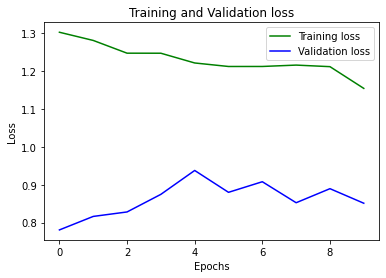

In [85]:
%matplotlib inline
NUM_EPOCHS=hyperparams['num_epochs']
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

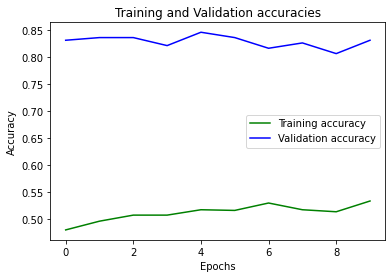

In [86]:
plt.plot(range(0,len(train_accuracies)), train_accuracies, 'g', label='Training accuracy')
plt.plot(range(0,len(train_accuracies)), val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

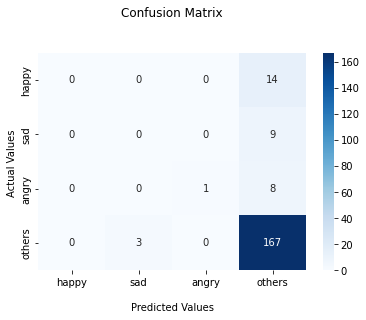

In [87]:
import seaborn as sns

cf_matrix = confusion_matrix(val_labels, val_predictions, labels=[0, 1, 2, 3])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["happy", "sad", "angry", "others"])
ax.yaxis.set_ticklabels(["happy", "sad", "angry", "others"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [89]:
precision_recall_fscore_support(val_labels, val_predictions, zero_division=0)

(array([0.        , 0.        , 1.        , 0.84343434]),
 array([0.        , 0.        , 0.11111111, 0.98235294]),
 array([0.       , 0.       , 0.2      , 0.9076087]),
 array([ 14,   9,   9, 170]))